<a href="https://colab.research.google.com/github/aliazak6/Virtual-Hear-Rate-Estimation/blob/master/CV_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
!pip install neurokit2
import neurokit2 as nk

In [ ]:
# Dataset folder
root = '/content/drive/MyDrive/UBFC_DATASET/DATASET_1/'

# Get folder list
dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]

# Iterate through all directories
#for dir_name in dirs:
dir_name = dirs[0]
vid_folder = os.path.join(root, dir_name)

# Load ground truth
gt_filename = os.path.join(vid_folder, 'gtdump.xmp')
if os.path.isfile(gt_filename):
    gt_data = np.genfromtxt(gt_filename, delimiter=',')
    gt_time = gt_data[:, 0] / 1000
    gt_hr = gt_data[:, 1]
    gt_trace = gt_data[:, 3]
else:
    gt_filename = os.path.join(vid_folder, 'ground_truth.txt')
    if os.path.isfile(gt_filename):
        gt_data = np.genfromtxt(gt_filename, delimiter=' ')
        gt_trace = gt_data[:, 0]
        gt_hr = gt_data[:, 1]
        gt_time = gt_data[:, 2]

# Normalize data (zero mean and unit variance)
gt_trace = (gt_trace - np.mean(gt_trace)) / np.std(gt_trace)

In [ ]:

# Open video file
vid_path = os.path.join(vid_folder, 'vid.avi')
vidObj = cv2.VideoCapture(vid_path)
fps = int(vidObj.get(cv2.CAP_PROP_FPS))
face_list = []
n = 0
fps = vidObj.get(cv2.CAP_PROP_FPS)
while True:
    ret, frame = vidObj.read()
    if not ret:
        break

    # Perform operations on frame (add your processing code here)
    """     """
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = cv2.CascadeClassifier('/content/drive/MyDrive/cv_project/haarcascade-frontalface-default.xml').detectMultiScale(frame_gray, 1.3, 5)
    for (x,y,w,h) in faces:
        # Crop face and append to face_list
        x_start = int(w*0.2)
        x_end = int(w-x_start)
        face = frame[y:y+h, x_start:x_end]
        face = cv2.resize(face, (224, 224))
        face_list.append(face)

    """     """
    #cv2_imshow(frame)
    #cv2.waitKey(1)
    #n += 1

vidObj.release()
cv2.destroyAllWindows()
face_list = np.array(face_list)

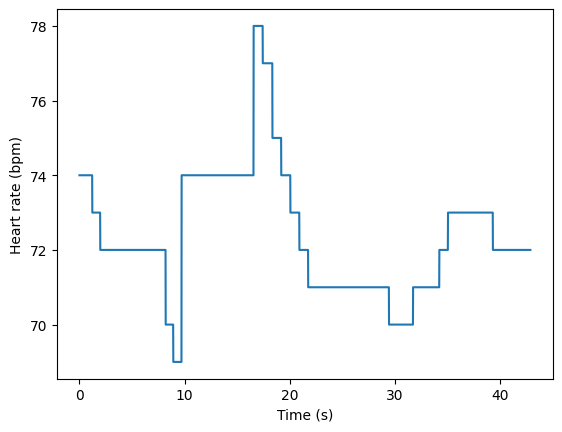

In [ ]:
# prompt: plot gt_hr

import matplotlib.pyplot as plt
plt.plot(gt_time, gt_hr)
plt.xlabel('Time (s)')
plt.ylabel('Heart rate (bpm)')
plt.show()


In [ ]:
def plot_means(mean):
  plt.plot(gt_time[:mean.shape[0]]*2, mean[:,0],'r', label='Red')
  plt.plot(gt_time[:mean.shape[0]]*2, mean[:,1],'g', label='Green')
  plt.plot(gt_time[:mean.shape[0]]*2, mean[:,2],'b', label='Blue')
  plt.xlabel('Time (s)')
  plt.ylabel('Mean RGB value')
  plt.legend()
  plt.show()

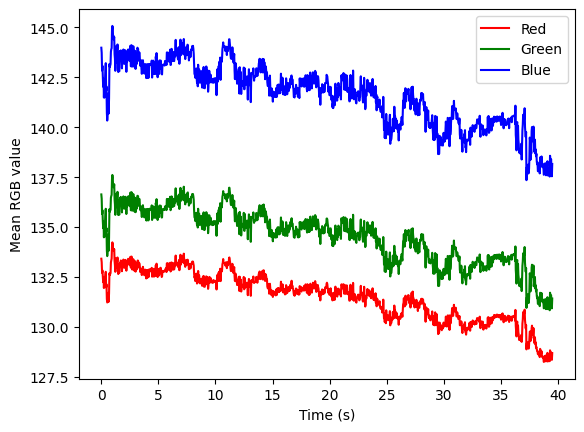

In [ ]:
# Find RGB means
mean = np.zeros((len(face_list), 3), dtype=np.float32)
mean_r = np.float32(0.0)
mean_g = np.float32(0.0)
mean_b = np.float32(0.0)
for i,face in enumerate(face_list):
    mean_r = face[:, :, 0].mean()
    mean_g = face[:, :, 1].mean()
    mean_b = face[:, :, 2].mean()
    mean[i] = mean_r, mean_g, mean_b
plot_means(mean)


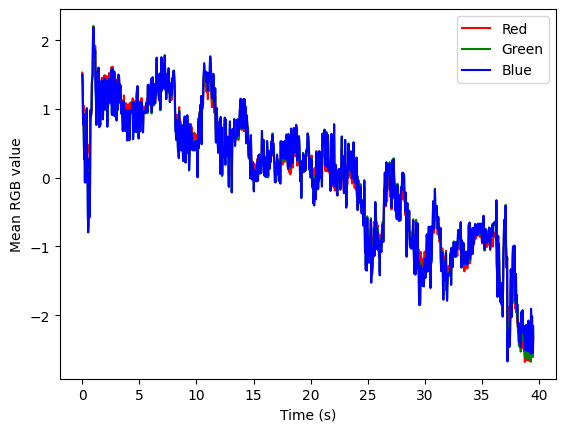

In [ ]:
# Normalize RGB means

mean[:,0] = (mean[:,0] - np.average(mean[:,0]))/np.std(mean[:,0])
mean[:,1] = (mean[:,1] - np.average(mean[:,1]))/np.std(mean[:,1])
mean[:,2] = (mean[:,2] - np.average(mean[:,2]))/np.std(mean[:,2])
plot_means(mean)

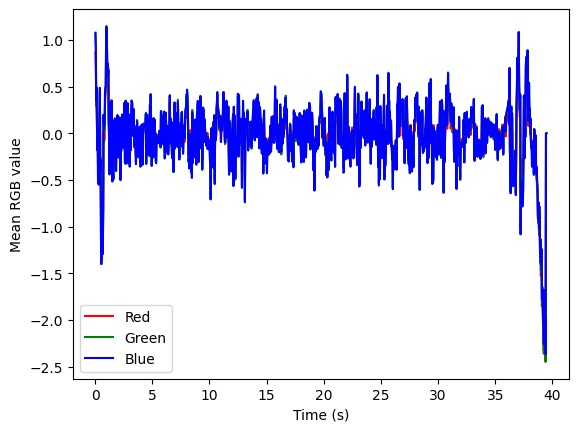

In [ ]:
detrended_mean = mean
detrended_mean[:,0] = nk.signal_detrend(mean[:,0], method="tarvainen2002", regularization=120)
detrended_mean[:,1] = nk.signal_detrend(mean[:,1], method="tarvainen2002", regularization=120)
detrended_mean[:,2] = nk.signal_detrend(mean[:,2], method="tarvainen2002", regularization=120)
plot_means(detrended_mean)

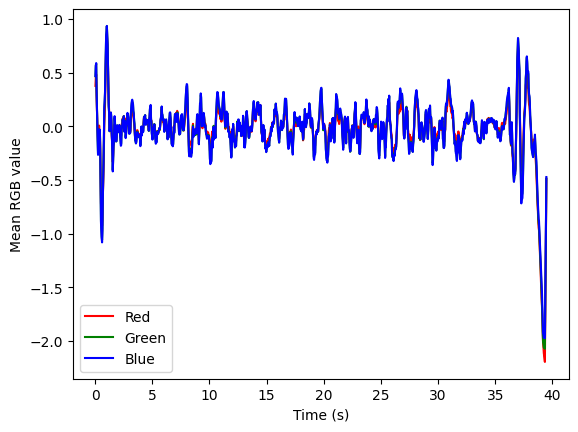

In [ ]:
# Moving average filter
window_size = int(fps*0.18)
kernel = np.ones(window_size) / window_size
filtered_mean = detrended_mean
filtered_mean[:,0] = np.convolve(detrended_mean[:,0],kernel,'same')
filtered_mean[:,1] = np.convolve(detrended_mean[:,1],kernel,'same')
filtered_mean[:,2] = np.convolve(detrended_mean[:,2],kernel,'same')
plot_means(filtered_mean)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


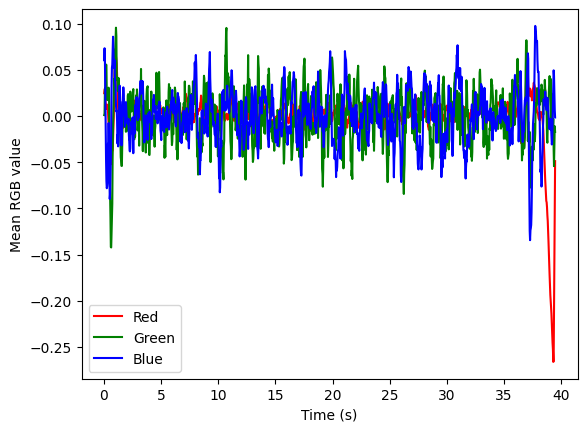

In [ ]:
from sklearn.decomposition import FastICA
transformer = FastICA(n_components = 3)
independent_signal = transformer.fit_transform(filtered_mean)
plot_means(independent_signal)

In [ ]:
from scipy.signal import periodogram
(f_r, S_r) = periodogram(independent_signal[:,0], fps, scaling='density')
(f_g, S_g) = periodogram(independent_signal[:,1], fps, scaling='density')
(f_b, S_b) = periodogram(independent_signal[:,2], fps, scaling='density')

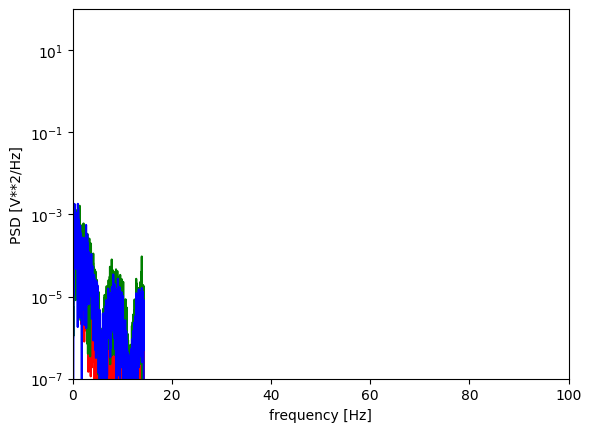

In [ ]:
plt.semilogy(f_r, S_r , 'r')
plt.semilogy(f_g, S_g, 'g')
plt.semilogy(f_b, S_b, 'b')
plt.ylim([1e-7, 1e2])
plt.xlim([0,100])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [ ]:
signal = independent_signal[:,np.argmax([max(S_r),max(S_g),max(S_b)])]
# Bundan sonra max veren sinyal channel ile devam edeceğiz

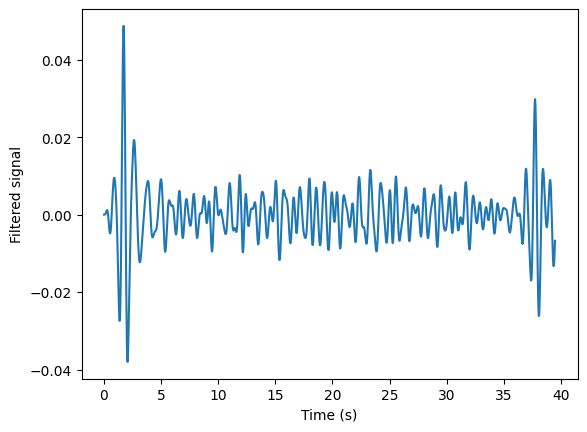

In [ ]:
# prompt: band pass filter between 0.8Hz and 2 Hz

import numpy as np
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

signal = independent_signal[:,0]
final_signal = butter_bandpass_filter(signal, 0.8, 2, fps, order=5)

plt.plot(gt_time[:final_signal.shape[0]]*2, final_signal)
plt.xlabel('Time (s)')
plt.ylabel('Filtered signal')
plt.show()


In [ ]:
# Max gücü olan frekans = nabız
(f_r, S_r) = periodogram(final_signal, fps, scaling='density')

f = f_r[S_r.argmax()]


In [ ]:
hr = 60 *f
hr

81.38484117455138

In [ ]:
np.mean(gt_hr)

72.40833959429001

Ortalamada 9 bpm'lik hata var nabızda.

Progress Raporunda
1. Daha küçük aralıklarla çalıştırıp grafik çizdirmek lazım.
Asıl raporda
2. Vakit kalırsa ROI selection aşaması iyileştirilebilir. Şimdilik viola jones ile yüzü bulup x'in %60ını alıyorum.
3. Image pyramid kullanılabilir.
4. Bir şekilde renk değişimini büyütürsek nabızı doğru bulduğumuzda sunumda iyi durur.



